## 1.

*Recogiendo los datos de coronavirus de la página https://ourworldindata.org/coronavirus-source-data* 

A partir de la letra de tu DNI, elige al país que empieza por dicha letra que más fallecidos tenga. Si el país elegido no está entre el top 20 de fallecidos, elige como país España.

En este caso, utilizaremos las columnas:

- Nuevos casos
- Nuevos fallecidos
- Población
- Fallecidos totales
- Casos totales

La fecha debe estar en el índice.

1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

2. Elimina la columna "Población".

3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

4. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y batches = 7 para este ejercicio y solo para la columna "nuevos casos".

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold, KFold, train_test_split, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor


In [4]:
df = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv") 

In [5]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [6]:
df.shape

(68533, 59)

#### Sacando el pais con "K" que más muertes tiene:

In [7]:
var = df["location"].str.startswith("K")

In [8]:
df2 = df[var]

In [9]:
df2["total_deaths"].sort_values(ascending=False).to_frame().head(1)

,total_deaths
32491,3135.0


In [10]:
df2.loc[df2["total_deaths"] ==3132.0 ,:]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
32490,KAZ,Asia,Kazakhstan,2021-02-11,248566.0,1033.0,1083.286,3132.0,1.0,1.857,...,24055.588,0.1,466.792,7.11,7.0,43.1,98.999,6.7,73.6,0.825


In [11]:
df = df[df['total_deaths'].notna()]

In [12]:
df.shape

(58846, 59)

In [13]:
#Eliminamos paises duplicados cogiendo el valor más alto (last) de total_deaths de ese pais!
df_comprobando = df.sort_values('total_deaths').drop_duplicates(subset='location', keep='last')
df_comprobando

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
25303,GRD,North America,Grenada,2021-01-24,147.0,0.0,1.143,1.0,0.0,0.000,...,13593.877,NaN,243.964,10.71,NaN,NaN,NaN,3.700,72.40,0.779
7793,BTN,Asia,Bhutan,2021-01-29,858.0,1.0,1.000,1.0,0.0,0.000,...,8708.597,1.5,217.066,9.75,NaN,NaN,79.807,1.700,71.78,0.654
41220,MNG,Asia,Mongolia,2021-02-12,2293.0,46.0,43.429,2.0,0.0,0.000,...,11840.846,0.5,460.043,4.82,5.500,46.500,71.180,7.000,69.87,0.737
22074,FJI,Oceania,Fiji,2021-01-22,55.0,0.0,0.286,2.0,0.0,0.000,...,8702.975,1.4,412.820,14.49,10.200,34.800,NaN,2.300,67.44,0.743
10505,BDI,Africa,Burundi,2021-02-11,1771.0,20.0,12.143,3.0,0.0,0.143,...,702.225,71.7,293.068,6.05,NaN,NaN,6.144,0.800,61.58,0.433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65339,USA,North America,United States,2021-02-12,27492023.0,99511.0,96893.000,480887.0,5443.0,3041.286,...,54225.446,1.2,151.089,10.79,19.100,24.600,NaN,2.770,78.86,0.926
21702,OWID_EUN,NaN,European Union,2021-02-12,20903320.0,82896.0,91158.429,509993.0,2551.0,2825.286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45403,OWID_NAM,NaN,North America,2021-02-12,31544358.0,118480.0,114674.714,699200.0,6949.0,4428.286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21315,OWID_EUR,NaN,Europe,2021-02-12,32162160.0,127652.0,133232.286,761945.0,4049.0,4264.429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
#Aqui vamos que Kazakhstan no está entre los primeros 20 paises con más muertes, por lo que vamos a coger España
df_comprobando.sort_values("total_deaths",ascending=False).head(25)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
67362,OWID_WRL,NaN,World,2021-02-11,107780490.0,439808.0,417500.286,2368680.0,14119.0,12272.429,...,15469.207,10.0,233.070,8.51,6.434,34.635,60.130,2.705,72.58,0.737
21252,NaN,NaN,Europe,2021-02-11,32034508.0,153785.0,143116.857,757896.0,4688.0,4533.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45269,NaN,NaN,North America,2021-02-11,31425878.0,124975.0,122085.286,692251.0,5571.0,4426.571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21638,NaN,NaN,European Union,2021-02-11,20820424.0,111235.0,100283.143,507442.0,3226.0,3045.857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65147,USA,North America,United States,2021-02-11,27392512.0,105353.0,101756.857,475444.0,3877.0,2781.143,...,54225.446,1.2,151.089,10.79,19.100,24.600,NaN,2.770,78.86,0.926
56998,NaN,NaN,South America,2021-02-11,16703528.0,84166.0,72723.429,436608.0,2517.0,1900.857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3579,NaN,NaN,Asia,2021-02-11,23865633.0,64988.0,66855.857,383700.0,848.0,894.143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9138,BRA,South America,Brazil,2021-02-11,9713909.0,54742.0,45373.714,236201.0,1351.0,1058.000,...,14103.452,3.4,177.961,8.11,10.100,17.900,NaN,2.200,75.88,0.765
40047,MEX,North America,Mexico,2021-02-11,1968566.0,10677.0,11760.143,171234.0,1474.0,1427.714,...,17336.469,2.5,152.783,13.06,6.900,21.400,87.847,1.380,75.05,0.779
28435,IND,Asia,India,2021-02-11,10880603.0,9309.0,11144.571,155447.0,87.0,89.143,...,6426.674,21.2,282.280,10.39,1.900,20.600,59.550,0.530,69.66,0.645


In [ ]:
### Cogemos España ya que Kazakhstan no está entre los primeros 20 con mas muertes

Nuevos casos

Nuevos fallecidos

Población

Fallecidos 

Casos totales


La fecha debe estar en el índice.

#### 1. Representa todas las columnas en un gráfica con diferentes magnitudes en el eje y para su correcta visualización.

In [45]:
df3 = df[["date","location","new_cases", "new_deaths", "population", "total_deaths", "total_cases"]]
df3

,date,location,new_cases,new_deaths,population,total_deaths,total_cases
27,2020-03-22,Afghanistan,4.0,1.0,38928341.0,1.0,34.0
28,2020-03-23,Afghanistan,7.0,0.0,38928341.0,1.0,41.0
29,2020-03-24,Afghanistan,2.0,0.0,38928341.0,1.0,43.0
30,2020-03-25,Afghanistan,33.0,1.0,38928341.0,2.0,76.0
31,2020-03-26,Afghanistan,4.0,1.0,38928341.0,3.0,80.0
...,...,...,...,...,...,...,...
68528,2021-02-08,Zimbabwe,106.0,13.0,14862927.0,1339.0,34658.0
68529,2021-02-09,Zimbabwe,123.0,14.0,14862927.0,1353.0,34781.0
68530,2021-02-10,Zimbabwe,83.0,11.0,14862927.0,1364.0,34864.0
68531,2021-02-11,Zimbabwe,0.0,0.0,14862927.0,1364.0,34864.0


In [47]:
df3["date"] = df3["date"].astype('datetime64[ns]')

In [49]:
filas_eliminar5 = df3[ df3['location'] != "Spain" ].index
df3.drop(filas_eliminar5 , inplace=True)


In [50]:
#data.set_index("First Name", inplace = True)
df3

,date,location,new_cases,new_deaths,population,total_deaths,total_cases
57902,2020-03-03,Spain,45.0,1.0,46754783.0,1.0,165.0
57903,2020-03-04,Spain,57.0,1.0,46754783.0,2.0,222.0
57904,2020-03-05,Spain,37.0,1.0,46754783.0,3.0,259.0
57905,2020-03-06,Spain,141.0,2.0,46754783.0,5.0,400.0
57906,2020-03-07,Spain,100.0,5.0,46754783.0,10.0,500.0
...,...,...,...,...,...,...,...
58244,2021-02-08,Spain,47095.0,909.0,46754783.0,62295.0,2989085.0
58245,2021-02-09,Spain,16402.0,766.0,46754783.0,63061.0,3005487.0
58246,2021-02-10,Spain,18114.0,643.0,46754783.0,63704.0,3023601.0
58247,2021-02-11,Spain,17853.0,513.0,46754783.0,64217.0,3041454.0


In [51]:
df3.set_index("date", inplace = True)

In [52]:
df3.head()

,location,new_cases,new_deaths,population,total_deaths,total_cases
date,,,,,,
2020-03-03,Spain,45.0,1.0,46754783.0,1.0,165.0
2020-03-04,Spain,57.0,1.0,46754783.0,2.0,222.0
2020-03-05,Spain,37.0,1.0,46754783.0,3.0,259.0
2020-03-06,Spain,141.0,2.0,46754783.0,5.0,400.0
2020-03-07,Spain,100.0,5.0,46754783.0,10.0,500.0


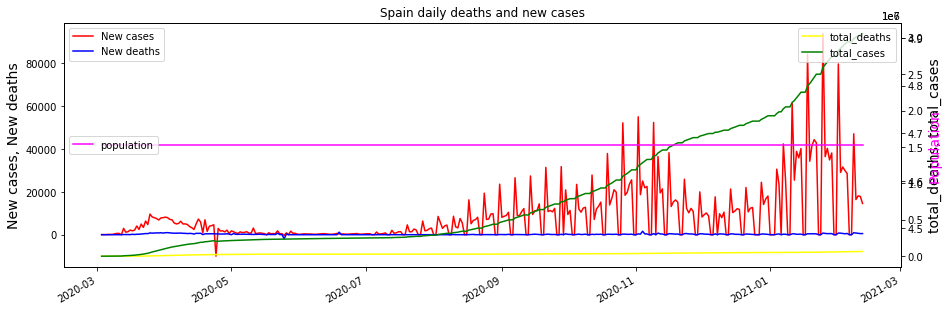

In [67]:
plt.rcParams["figure.figsize"] = [15, 5]

fig,ax = plt.subplots()

ax.plot(df3.index, df3.new_cases, color="red", label="New cases")
ax.plot(df3.index, df3.new_deaths,color="blue", label="New deaths")
ax.set_ylabel("New cases, New deaths",fontsize=14)
plt.title("Spain daily deaths and new cases")
fig.autofmt_xdate()
ax.legend()


ax2=ax.twinx()
ax2.plot(df3.index, df3.total_deaths,color="yellow", label="total_deaths")
ax2.plot(df3.index, df3.total_cases,color="green", label="total_cases")
ax2.set_ylabel("total_deaths, total_cases",fontsize=14)
ax2.legend(loc='upper right')


ax3=ax.twinx()
ax3.plot(df3.index, df3.population,color="magenta", label="population")
ax3.set_ylabel("Population",color="magenta",fontsize=14)
ax3.legend(loc='center left')


plt.show()

#### 2. Elimina la columna "Población".

In [69]:
df3.drop(['population'], axis = 1) 

,location,new_cases,new_deaths,total_deaths,total_cases
date,,,,,
2020-03-03,Spain,45.0,1.0,1.0,165.0
2020-03-04,Spain,57.0,1.0,2.0,222.0
2020-03-05,Spain,37.0,1.0,3.0,259.0
2020-03-06,Spain,141.0,2.0,5.0,400.0
2020-03-07,Spain,100.0,5.0,10.0,500.0
...,...,...,...,...,...
2021-02-08,Spain,47095.0,909.0,62295.0,2989085.0
2021-02-09,Spain,16402.0,766.0,63061.0,3005487.0
2021-02-10,Spain,18114.0,643.0,63704.0,3023601.0


In [83]:
print(df["new_cases"].dtypes)
print(df["new_deaths"].dtypes)
print(df["total_deaths"].dtypes)
print(df["total_cases"].dtypes)

float64
float64
float64
float64


#### 3. Entrena los algoritmos de regresión que hemos visto hasta ahora para predecir dos columnas por separado: Nuevos casos y Nuevos fallecidos. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento. ¿Qué error se comete? ¿crees que los algoritmos de ML vistos hasta ahora son buenos para realizar un forecast de una serie temporal viendo los resultados?

In [ ]:
#y = nuevos casos
#y = nuevos fallecidos

In [88]:
y = df3["new_cases"]
X = df3.drop(columns=["new_cases","location"])
X = np.array(X)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [101]:
%%time
model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
#model = LogisticRegression(n_jobs=-4, verbose=True, C=1., penalty="l2", warm_start=True)  # este debe ser el que haya encontrado como el mejor

# Opción para entrenar usando cross validation de forma individual
k_fold = RepeatedKFold(n_splits=2, n_repeats=2)
val_score = []
train_score = []

for i, (train, val) in enumerate(k_fold.split(X_train)): #Los valores que coge de train y de validacion
    #print("############\n############")
    print("Iteración:", i+1, "/", 10)
    # print("train/índices batch:", train)
    # print("batch_size:", len(train))
    # print("val:", val)
    # print("val_size:", len(val))
    # print("batch:", X_train[train])

    # train the model
    model.fit(X_train[train], y_train[train])
    score_val = model.score(X_train[val], y_train[val])
    val_score.append(score_val)
    score_train = model.score(X_train[train], y_train[train])
    train_score.append(score_train)
    print(train_score)
    

Iteración: 1 / 10
[0.9539863115263764]
Iteración: 2 / 10
[0.9539863115263764, 0.9559183550686238]
Iteración: 3 / 10
[0.9539863115263764, 0.9559183550686238, 0.9404048837773683]
Iteración: 4 / 10
[0.9539863115263764, 0.9559183550686238, 0.9404048837773683, 0.9502183073893036]
Wall time: 3.75 s


In [102]:
%%time
model = LinearRegression()

# Opción para entrenar usando cross validation de forma individual
k_fold = RepeatedKFold(n_splits=2, n_repeats=2)
val_score = []
train_score = []

for i, (train, val) in enumerate(k_fold.split(X_train)): #Los valores que coge de train y de validacion
    #print("############\n############")
    print("Iteración:", i+1, "/", 10)
    # print("train/índices batch:", train)
    # print("batch_size:", len(train))
    # print("val:", val)
    # print("val_size:", len(val))
    # print("batch:", X_train[train])

    # train the model
    model.fit(X_train[train], y_train[train])
    score_val = model.score(X_train[val], y_train[val])
    val_score.append(score_val)
    score_train = model.score(X_train[train], y_train[train])
    train_score.append(score_train)
    print(train_score)
    

Iteración: 1 / 10
[0.51964121540748]
Iteración: 2 / 10
[0.51964121540748, 0.38706981508844684]
Iteración: 3 / 10
[0.51964121540748, 0.38706981508844684, 0.3978245659292208]
Iteración: 4 / 10
[0.51964121540748, 0.38706981508844684, 0.3978245659292208, 0.506810548437703]
Wall time: 19 ms


In [103]:
%%time
model = SVR(kernel="rbf")
#model = LogisticRegression(n_jobs=-4, verbose=True, C=1., penalty="l2", warm_start=True)  # este debe ser el que haya encontrado como el mejor

# Opción para entrenar usando cross validation de forma individual
k_fold = RepeatedKFold(n_splits=2, n_repeats=2)
val_score = []
train_score = []

for i, (train, val) in enumerate(k_fold.split(X_train)): #Los valores que coge de train y de validacion
    #print("############\n############")
    print("Iteración:", i+1, "/", 10)
    # print("train/índices batch:", train)
    # print("batch_size:", len(train))
    # print("val:", val)
    # print("val_size:", len(val))
    # print("batch:", X_train[train])

    # train the model
    model.fit(X_train[train], y_train[train])
    score_val = model.score(X_train[val], y_train[val])
    val_score.append(score_val)
    score_train = model.score(X_train[train], y_train[train])
    train_score.append(score_train)
    print(train_score)

Iteración: 1 / 10
[-0.26502503401149724]
Iteración: 2 / 10
[-0.26502503401149724, -0.12949528025278734]
Iteración: 3 / 10
[-0.26502503401149724, -0.12949528025278734, -0.19844461467145824]
Iteración: 4 / 10
[-0.26502503401149724, -0.12949528025278734, -0.19844461467145824, -0.2199728526431537]
Wall time: 35.9 ms


El algoritmo Random Forest si que seria bueno para realizar un forecast de una serie temporal